In [214]:
%pip install numpy
%pip install pandas
%pip install matplotlib
%pip install ipython

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [215]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from IPython.core.display_functions import clear_output
from IPython.display import display

import os
import math

In [216]:
species_values = ['Iris-setosa','Iris-versicolor','Iris-virginica']

In [217]:
seed = 42

np.random.seed(seed) # set seed for reproducibility

shuffle_seed = np.random.randint(0,1000000) # shuffle seed for reproducibility

In [218]:
read_from_checkpoint = False

if(not read_from_checkpoint):
    all_data = pd.read_csv("iris.csv")
    all_data = all_data.sample( frac=1, random_state=shuffle_seed) # shuffle
    for species_value in species_values:
        all_data['Species_' + species_value] = (all_data['Species'] == species_value).astype(int)



    cutoff = math.floor(len(all_data) * 0.8)

    training_data = all_data.iloc[:cutoff,:].reset_index(drop=True)
    testing_data = all_data.iloc[cutoff:,:].reset_index(drop=True)

    os.makedirs("checkpoint",exist_ok=True)
    training_data.to_csv('checkpoint/trainingdata.csv',index=False)
    testing_data.to_csv('checkpoint/testingdata.csv',index=False)
else:
    training_data = pd.read_csv('checkpoint/trainingdata.csv')
    testing_data = pd.read_csv('checkpoint/testingdata.csv')


training_data

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species,Species_Iris-setosa,Species_Iris-versicolor,Species_Iris-virginica
0,58,4.9,2.4,3.3,1.0,Iris-versicolor,0,1,0
1,100,5.7,2.8,4.1,1.3,Iris-versicolor,0,1,0
2,116,6.4,3.2,5.3,2.3,Iris-virginica,0,0,1
3,138,6.4,3.1,5.5,1.8,Iris-virginica,0,0,1
4,114,5.7,2.5,5.0,2.0,Iris-virginica,0,0,1
...,...,...,...,...,...,...,...,...,...
115,4,4.6,3.1,1.5,0.2,Iris-setosa,1,0,0
116,32,5.4,3.4,1.5,0.4,Iris-setosa,1,0,0
117,72,6.1,2.8,4.0,1.3,Iris-versicolor,0,1,0
118,113,6.8,3.0,5.5,2.1,Iris-virginica,0,0,1


In [219]:
def sigmoid(logit): # sigmoid
  return 1/(1+ np.exp(-logit))

def leaky_relu(logit): # leaky relu
  return np.where(logit>0.0,logit,0.01*logit)

def softmax(logit): # softmax
  return np.exp(logit)/np.sum(np.exp(logit))

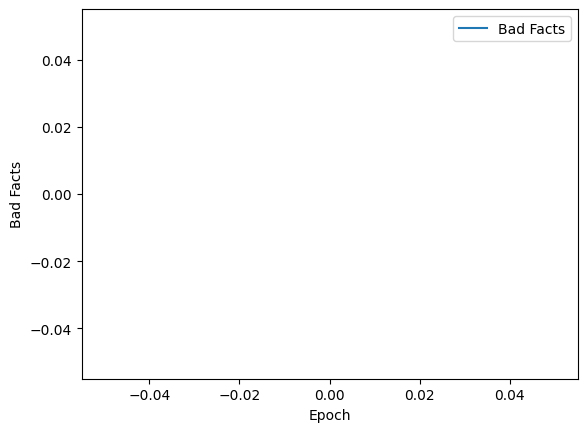

In [220]:
bad_facts_fig, bad_facts_ax = plt.subplots()
bad_facts_ln, = bad_facts_ax.plot([], [], label='Bad Facts')

bad_facts_ax.set_xlabel('Epoch')
bad_facts_ax.set_ylabel('Bad Facts')
bad_facts_ax.legend(loc='upper right')

def update_graphs(): 
    bad_facts_ln.set_data(range(len(bad_facts_per_epoch)),bad_facts_per_epoch)
    bad_facts_fig.gca().relim()
    bad_facts_fig.gca().autoscale_view()
    
    clear_output(wait=True)
    display(bad_facts_fig)

In [221]:
layer0_size = 4 #input size
layer1_size = 4 #hidden layer size
layer2_size = 3 #output size


layer_1_dropout = np.zeros(layer1_size)

layer0_outputs = np.zeros(layer0_size)
layer1_outputs = np.zeros(layer1_size)
layer2_outputs = np.zeros(layer2_size)


layer1_logit = np.zeros(layer1_size)
layer2_logit = np.zeros(layer2_size)


layer1_weights = np.random.uniform(-1,1,size=(layer0_size,layer1_size))
layer2_weights = np.random.uniform(-1,1,size=(layer1_size,layer2_size))


layer2_delta = np.zeros(layer2_size)
layer1_delta = np.zeros(layer1_size)

update_graph_live = True
update_graph_intervals = 1000

error_threshold = 0.2
learning_rate = 0.2
layer_1_dropout_prob = 0.0

layer1_activation_function = "sigmoid"
layer2_activation_function = "sigmoid"

bad_facts_per_epoch = []

In [222]:
def forward_prop_layer(layer_inputs, layer_weights, layer_logit, layer_outputs,activation_function, use_dropout = False, layer_dropout = None, layer_dropout_probability = 0):
    np.matmul(layer_inputs,layer_weights,out=layer_logit)
        
    if activation_function == "sigmoid":
        layer_outputs[:] = sigmoid(layer_logit)
    elif activation_function == "leaky_relu":
        layer_outputs[:] = leaky_relu(layer_logit)
    elif activation_function == "softmax":
        layer_outputs[:] = softmax(layer_logit)
    else:
        raise Exception("Unknown activation function",activation_function)
    
    if use_dropout:
        layer_dropout[:] = np.random.rand(*layer_dropout.shape)>layer_dropout_probability
        layer_outputs *= layer_dropout
    

In [223]:
def forward_prop(inputs,use_dropout):
    layer0_outputs[:] = np.array(inputs)
    forward_prop_layer(layer0_outputs,layer1_weights,layer1_logit,layer1_outputs,layer1_activation_function,use_dropout,layer_1_dropout,layer_1_dropout_prob)
    forward_prop_layer(layer1_outputs,layer2_weights,layer2_logit,layer2_outputs,layer2_activation_function)
    

In [224]:
def back_prop_output_layer(layer_outputs,targets,layer_weights,layer_delta,prev_layer_ouputs,activation_function):
    
    if activation_function == "sigmoid":
        layer_delta[:] = layer_outputs*(1-layer_outputs) * (targets-layer_outputs)
    elif activation_function == "leaky_relu":
        layer_delta[:] = np.where(layer_outputs>0.0,1.0,0.01) * (targets-layer_outputs)
    elif activation_function == "softmax":
        layer_delta[:] = layer_outputs - targets
    else:
        raise Exception("Unknown activation function",activation_function)

    delta_W = np.outer(prev_layer_ouputs,layer_delta.T) * learning_rate

    layer_weights += delta_W

    

In [225]:
def back_prop_hidden_layer(output_weights,layer_outputs,layer_weights,prev_layer_outputs,next_layer_deltas,layer_delta,activation_function):


    sums = []

    for p in range(output_weights.shape[0]):
        sum = 0
        for q in range(output_weights.shape[1]):
            sum += next_layer_deltas[q] * output_weights[p,q]
        sums.append(sum)


    if activation_function == "sigmoid":
        layer_delta[:] = layer_outputs*(1-layer_outputs) * np.array(sums)
    elif activation_function == "leaky_relu":
        layer_delta[:] = np.where(layer_outputs>0.0,1.0,0.01) * np.array(sums)
    else:
        raise Exception("Unknown activation function",activation_function)

    delta_W = np.outer(prev_layer_outputs,layer_delta.T) * learning_rate

    layer_weights += delta_W

In [226]:
def back_prop(target):
    back_prop_output_layer(layer2_outputs,target,layer2_weights,layer2_delta,layer1_outputs,layer2_activation_function)
    back_prop_hidden_layer(layer2_weights,layer1_outputs,layer1_weights,layer0_outputs,layer2_delta,layer1_delta,layer1_activation_function)

In [227]:
def train():
    
    
    last_improved_epoch = 0
    last_improved_epoch_bad_facts = len(training_data.index)
    last_improved_epoch_threshold = 500
    
    for epoch in range(10000):
        bad_facts = 0
        for i in range(len(training_data.index)):
    
            forward_prop(training_data.loc[i,['SepalLengthCm','SepalWidthCm','PetalLengthCm','PetalWidthCm']].values.astype(float),True)
    
            target = training_data.loc[i,['Species_Iris-setosa','Species_Iris-versicolor','Species_Iris-virginica']].values.astype(float)
            
            error = target - layer2_outputs
    
            output_outside_threshold = np.abs(error) > error_threshold
    
            if np.any(output_outside_threshold):
                bad_facts += 1
                
                back_prop(target)
            
             
        
        bad_facts_per_epoch.append(bad_facts)
        
        if update_graph_live and epoch%update_graph_intervals == 0:
            update_graphs()
            
        if bad_facts < last_improved_epoch_bad_facts:
            last_improved_epoch = epoch
            last_improved_epoch_bad_facts = bad_facts
        elif epoch - last_improved_epoch > last_improved_epoch_threshold:
            print("Early stopping")
            update_graphs()
            return epoch
            
        if bad_facts == 0:
            update_graphs()
            return


In [228]:
def test():
    success = []
    
    for i in range(len(testing_data.index)):
    
            forward_prop(testing_data.loc[i,['SepalLengthCm','SepalWidthCm','PetalLengthCm','PetalWidthCm']].values.astype(float),False)
            
            target = testing_data.loc[i,['Species_Iris-setosa','Species_Iris-versicolor','Species_Iris-virginica']].values.astype(float)
    
            target_class = species_values[np.argmax(target)]
            output_class = species_values[np.argmax(layer2_outputs)]
    
            success.append(target_class == output_class)
        
    accuracy = np.sum(success)/len(success)
    return accuracy

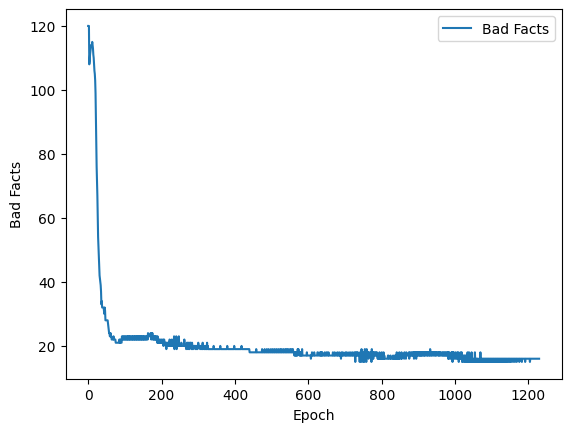

1.0

In [229]:
train()
accuracy = test()
print("Accuracy:",accuracy)